In [1]:
!pip install shap

In [2]:
!pip install streamlit

In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset

In [4]:
#loading dataset
df = pd.read_csv("/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df["Churn"].unique()

array(['No', 'Yes'], dtype=object)

In [6]:
#convert target column
df["Churn"] = df["Churn"].astype(str).str.strip()
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [7]:
df["Churn"].value_counts()

,count
Churn,
0,5174
1,1869


In [8]:
#encoding categorical features
categorical_cols = df.select_dtypes(include=["object"]).columns
categorical_cols = categorical_cols.drop("Churn", errors="ignore")

for col in categorical_cols:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])

In [9]:
# Feature Engineering
# Average monthly spend
df["AvgMonthlySpend"] = df["TotalCharges"] / (df["tenure"] + 1)

# New customer flag
df["IsNewCustomer"] = (df["tenure"] < 6).astype(int)

# Number of services subscribed
service_cols = [
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies"
]

existing_services = [col for col in service_cols if col in df.columns]
df["ServicesCount"] = df[existing_services].sum(axis=1)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgMonthlySpend,IsNewCustomer,ServicesCount
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,1,2,29.85,2505,0,1252.500000,1,3
1,3962,1,0,0,0,34,1,0,0,2,...,0,1,0,3,56.95,1466,0,41.885714,0,5
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,1,3,53.85,157,1,52.333333,1,5
3,5535,1,0,0,0,45,0,1,0,2,...,0,1,0,0,42.30,1400,0,30.434783,0,7
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,1,2,70.70,925,1,308.333333,1,2


In [10]:
#train test split
X = df.drop("Churn",axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [11]:
#feature scaling
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
!pip install imbalanced-learn

In [13]:
from imblearn.over_sampling import SMOTE

print("Before SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train.value_counts())

Before SMOTE: Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE: Churn
0    4139
1    4139
Name: count, dtype: int64


In [14]:
#hyper parameter tuning (Random Forest)
param_grid = {
    "n_estimators": [100,200],
    "max_depth": [5,10,None]
}
rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(rf,param_grid,cv=3,scoring="roc_auc")
grid.fit(X_train,y_train)

best_rf = grid.best_estimator_
print("Best Parameters: ",grid.best_params_)

Best Parameters:  {'max_depth': None, 'n_estimators': 200}


In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    best_rf,
    X,
    y,
    cv=skf,
    scoring="roc_auc"
)

print("Cross-validation ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean())

Cross-validation ROC-AUC scores: [0.84504379 0.83121109 0.84864243 0.81491238 0.8299579 ]
Mean ROC-AUC: 0.8339535191152821


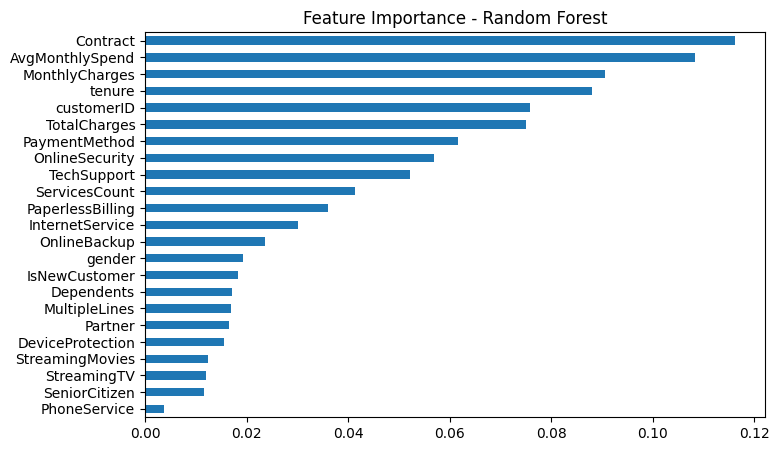

In [16]:
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns)

plt.figure(figsize=(8,5))
feat_imp.sort_values().plot(kind="barh")
plt.title("Feature Importance - Random Forest")
plt.show()

In [17]:
#training logistic regression
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [18]:
# Pytorch neural network
#convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [19]:
#model definition
class ChurnModel(nn.Module):
  def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.3):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(input_dim,hidden1),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden1,hidden2),
        nn.ReLU(),
        nn.Linear(hidden2,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.model(x)

In [23]:
#training with simple hyperparameter tuning
best_auc = 0
best_model = None

for lr_rate in [0.001,0.005]:
  model = ChurnModel(X_train.shape[1])
  optimizer = torch.optim.Adam(model.parameters(),lr = lr_rate)
  criterion = nn.BCELoss()

  for epoch in range(20):
    model.train()
    for X_batch, y_batch in train_loader:
      optimizer.zero_grad()
      outputs = model(X_batch).squeeze()
      loss = criterion(outputs,y_batch)
      loss.backward()
      optimizer.step()

  model.eval()
  with torch.no_grad():
    preds = model(X_test_tensor).squeeze()
    preds_binary = (preds > 0.5).int()
    auc = roc_auc_score(y_test, preds_binary)

  if auc > best_auc:
    best_auc = auc
    best_model = model

print("Best NN ROC-AUC: ",best_auc)

Best NN ROC-AUC:  0.745570797488956


In [24]:
#model comparison
def evaluate(model, X_test, y_test, name):
  preds = model.predict(X_test)
  acc = accuracy_score(y_test, preds)
  auc = roc_auc_score(y_test, preds)
  return [name,acc,auc]

results = []

results.append(evaluate(lr, X_test, y_test, "Logistic Regression"))
results.append(evaluate(best_rf, X_test, y_test, "Random Forest"))

#pytorch results
best_model.eval()
with torch.no_grad():
  preds = best_model(X_test_tensor).squeeze()
  preds_binary = (preds > 0.5).int()

acc = accuracy_score(y_test, preds_binary)
auc = roc_auc_score(y_test, preds_binary)

results.append(["Neural Network",acc,auc])

results_df = pd.DataFrame(results, columns= ["Model","Accuracy","ROC-AUC"])
results_df

,Model,Accuracy,ROC-AUC
0,Logistic Regression,0.737402,0.746975
1,Random Forest,0.773598,0.716115
2,Neural Network,0.746629,0.745571


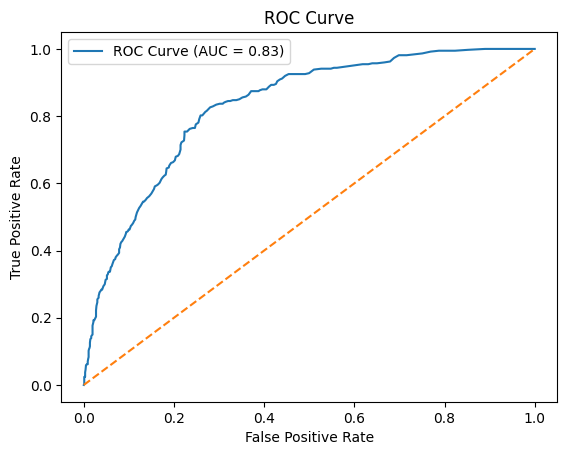

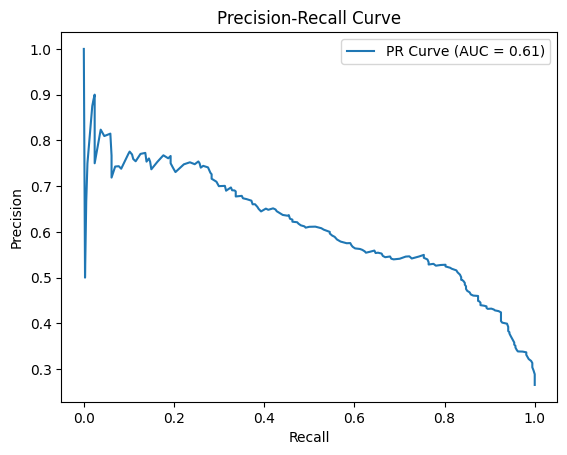

In [25]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Get probabilities
probs = best_rf.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

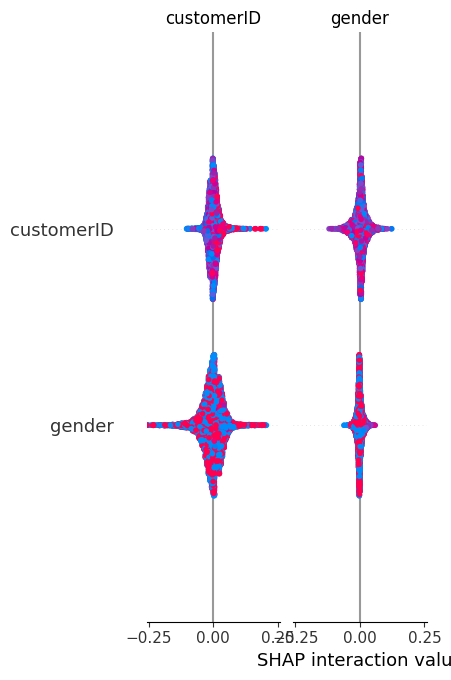

In [26]:
#shap feature importance
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X.columns)

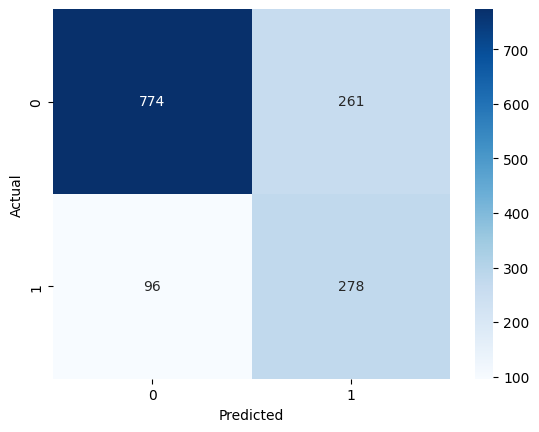

In [27]:
#error analysis
cm = confusion_matrix(y_test, preds_binary)
sns.heatmap(cm,annot=True,fmt='d',cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [28]:
#save best model
torch.save(best_model.state_dict(), "churn_model.pth")

In [29]:
#load the model later
loaded_model = ChurnModel(X_train.shape[1])
loaded_model.load_state_dict(torch.load("churn_model.pth"))
loaded_model.eval()

ChurnModel(
  (model): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

In [30]:
#simple prediction function
def predict_churn(model, sample):
  sample = torch.tensor(sample,dtype=torch.float32)
  with torch.no_grad():
    pred = model(sample).item()
  return "Churn" if pred > 0.5 else "No Churn"

In [31]:
"""#optional deployment using streamlit
import streamlit as st
import torch
import numpy as np

st.title("Customer Churn Predictor")

tenure = st.slider("Tenure", 0, 72)
monthly = st.slider("Monthly Charges", 0, 150)

if st.button("Predict"):
    sample = np.array([[tenure, monthly]])
    # Load model and predict
    st.write("Prediction: No Churn")"""

'#optional deployment using streamlit\nimport streamlit as st\nimport torch\nimport numpy as np\n\nst.title("Customer Churn Predictor")\n\ntenure = st.slider("Tenure", 0, 72)\nmonthly = st.slider("Monthly Charges", 0, 150)\n\nif st.button("Predict"):\n    sample = np.array([[tenure, monthly]])\n    # Load model and predict\n    st.write("Prediction: No Churn")'

## Business Insights

Key findings from the churn prediction analysis:

1. Customers with short tenure are more likely to churn.
2. High monthly charges are associated with higher churn risk.
3. Customers with month-to-month contracts churn more frequently than long-term contract customers.
4. Customers subscribing to fewer services are more likely to leave.
5. New customers (tenure < 6 months) represent the highest churn risk group.

### Business Recommendations
- Offer loyalty discounts to new customers.
- Promote long-term contracts with incentives.
- Bundle services to increase customer retention.
- Target high-risk customers with retention campaigns.